In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt  # Added for plotting

In [2]:
# Load the dataset
df = pd.read_csv("last1.csv")

# Fix column names by stripping spaces
df.columns = df.columns.str.strip()

# Create Date index
df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('Date', inplace=True)


In [3]:
# Encode target variable (binary: 1 for fire, 0 for not fire)
df['Fire'] = df['Classes'].apply(lambda x: 1 if 'fire' in x.lower() else 0)

# Select features and target
features = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
X = df[features]
y = df['Fire']

In [4]:
# Split into train and test (chronological split, ~80% train)
train_size = int(len(df) * 0.8)
train_X = X.iloc[:train_size]
test_X = X.iloc[train_size:]
train_y = y.iloc[:train_size]
test_y = y.iloc[train_size:]

In [5]:
# Scale features
feature_scaler = MinMaxScaler()
feature_scaler.fit(train_X)
scaled_train_X = feature_scaler.transform(train_X)
scaled_test_X = feature_scaler.transform(test_X)

In [6]:
# Reshape target for consistency (though binary, we treat as float)
train_y_np = train_y.values.reshape(-1, 1).astype(float)
test_y_np = test_y.values.reshape(-1, 1).astype(float)

In [7]:
# We don't scale binary targets typically, but for consistency with original code
target_scaler = MinMaxScaler()
target_scaler.fit(train_y_np)
scaled_train_y = target_scaler.transform(train_y_np)
scaled_test_y = target_scaler.transform(test_y_np)


In [8]:
# Parameters for time series generator
batch = 1
input_length = 12  # Using similar input length as original code
features_count = len(features)

In [9]:
# Generate time series sequences for training
generator = TimeseriesGenerator(scaled_train_X, scaled_train_y, length=input_length, batch_size=batch)

# Generate test sequences
test_generator = TimeseriesGenerator(scaled_test_X, scaled_test_y, length=input_length, batch_size=batch)

In [10]:
# Build the model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(input_length, features_count)))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(generator, epochs=10)

Epoch 1/10
85/85 [==============================] - 3s 15ms/step - loss: 0.1441 - accuracy: 0.9647
Epoch 2/10
85/85 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
85/85 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/10
85/85 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/10
85/85 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 6/10
85/85 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 7/10
85/85 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 8/10
85/85 [==============================] - 1s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/10
85/85 [==============================] - 1s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/10
85/85 [==============================] - 1s 16ms/step - loss: 0.0

13/13 [==============================] - 0s 3ms/step


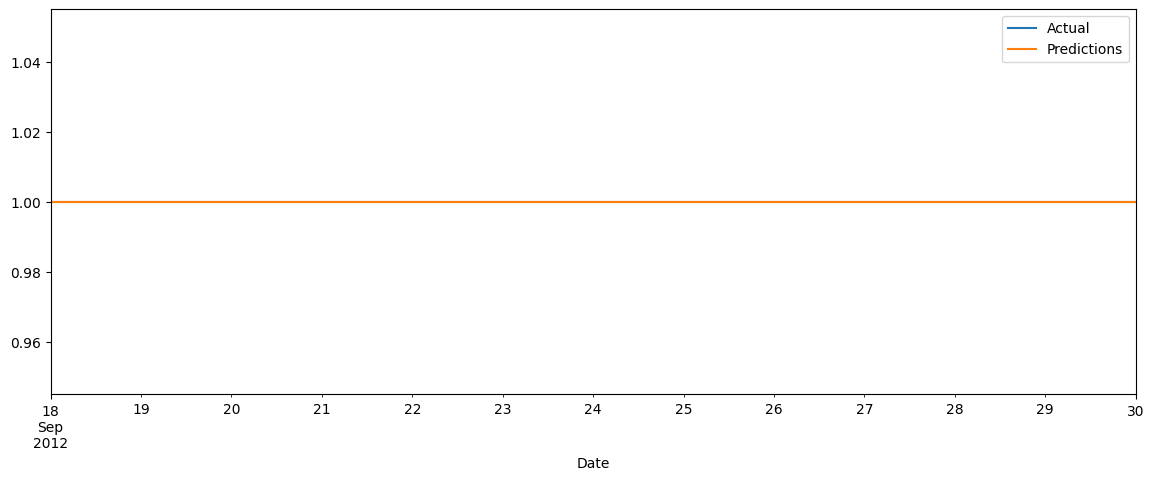

In [11]:
# Predict on test sequences
scaled_predictions = model.predict(test_generator)

# Inverse transform predictions and threshold for binary
true_predictions = target_scaler.inverse_transform(scaled_predictions)
binary_predictions = (true_predictions > 0.5).astype(int)

# Add predictions to test dataframe (aligning for sequence length)
test_df = test_X.iloc[input_length:].copy()
test_df['Actual'] = test_y.iloc[input_length:]
test_df['Predictions'] = binary_predictions.flatten()  # Flatten to match shape

# Plot actual vs predictions
test_df[['Actual', 'Predictions']].plot(figsize=(14, 5))
plt.show()  # Explicitly show the plot